<a href="https://colab.research.google.com/github/adityasengar/diffusion_model/blob/main/Reverse_process_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [ ]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [ ]:
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),)

        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(),
                                                         nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])

    def forward(self, x, t):

        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std



In [ ]:
model = MLP()
t = 5
x = torch.randn((64, 2))
mu, std = model(x, t)

print(mu.shape)
print(std.shape)

torch.Size([64, 2])
torch.Size([64, 2])


In [ ]:
class DiffusionModel():

    def __init__(self, T, mlp_model: nn.Module):

        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)

        self.T = T
        self.mlp_model = mlp_model

    def forward_process(self, x0, t):
        """
        :param t: Number of diffusion steps
        """

        assert t > 0, 't should be greater than 0'
        assert t <= self.T, f't should be lower or equal than {self.T}'

        t = t -1 # Because we start indexing at 0

        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)

        return mu + epsilon * std # data ~ N(mu, std)

    def reverse_process(self, xt, t):
        """
        :param t: Number of diffusion steps
        """

        assert t > 0, 't should be greater than 0'
        assert t <= self.T, f't should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(x0)

        return mu + epsilon * std # data ~ N(mu, std)



In [ ]:
x0 = sample_batch(3_000)
model = DiffusionModel(40,model)
xT = model.forward_process(x0, 20)

In [ ]:
x0

tensor([[-0.8242,  0.6255],
        [ 0.5072, -0.4942],
        [-0.8618,  0.5824],
        ...,
        [ 0.6890, -0.2861],
        [-0.4155, -1.1491],
        [-1.0631, -0.3988]], dtype=torch.float64)

In [ ]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0179, -0.1846], dtype=torch.float64)
tensor([0.7078, 0.6679], dtype=torch.float64)


In [ ]:
xT

tensor([[-0.8835,  0.6094],
        [ 0.3369, -0.4571],
        [-1.0067,  0.6392],
        ...,
        [ 0.7399, -0.3765],
        [-0.3671, -1.1841],
        [-0.7869, -0.2922]], dtype=torch.float64)

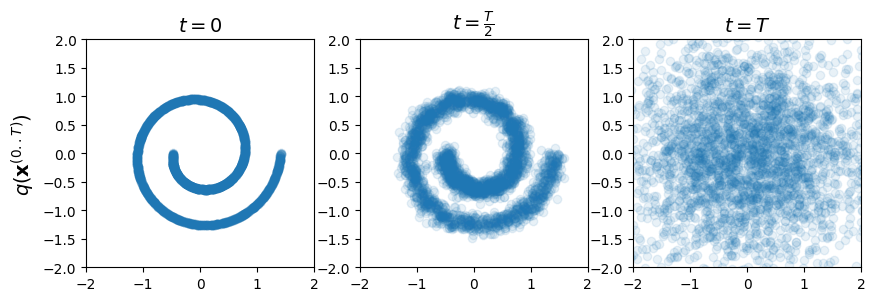

In [ ]:
fontsize = 14
fig = plt.figure(figsize=(10, 3))

data = [x0, model.forward_process(x0, 20), model.forward_process(x0, 40)]
for i in range(3):

    plt.subplot(1, 3, 1+i)
    plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')

    if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
    if i == 0: plt.title(r'$t=0$', fontsize=fontsize)
    if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
    if i == 2: plt.title(r'$t=T$', fontsize=fontsize)
plt.savefig('forward_process.png', bbox_inches='tight')